In [1]:
%tensorflow_version 2.x
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
# additional imports 

import numpy as np
import matplotlib.pyplot as plt

# layers
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
# model
from tensorflow.keras.models import Model

# dataset
from tensorflow.keras.datasets import cifar10

In [3]:
# load the dataset
cifar10_dataset = cifar10.load_data() # this returns 2 tuple, first one is train set and the second one is test set
# split the dataset into train and test set
(x_train, y_train), (x_test, y_test) = cifar10_dataset
# now let's çlook at the shapes, we may need to process the data before we build the model
print('Shape of X: \n Train: {} | Test: {}'.format(x_train.shape, x_test.shape))
print('Shape of Y: \n Train: {} | Test: {}'.format(y_train.shape, y_test.shape))

Shape of X: 
 Train: (50000, 32, 32, 3) | Test: (10000, 32, 32, 3)
Shape of Y: 
 Train: (50000, 1) | Test: (10000, 1)


In [0]:
# The X already have a dimension for color channels so its okay.
# But the pixel values are in [0,255]. I need to divide it by 255 so the range will reduce to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0
# Also the Y is in the shape of (N,1), we need to flatten it 
y_train, y_test = y_train.flatten(), y_test.flatten()

In [5]:
# how much classes we have?
K = len(set(y_train))
print(K)

10


In [0]:
# Build the model using functional API
i = Input(shape = x_train[0].shape)
# x = Conv2D(32, (3,3), strides = 2, activation = 'relu')(i)
# x = Conv2D(64, (3,3), strides = 2, activation = 'relu')(x)
# x = Conv2D(128, (3,3), strides = 2, activation = 'relu')(x)

# Now make the improvements using batch normalization and data augmention
# we don't need to use "strides" argument since we use max pooling layer
# also using 'same' mode convolution so the output will be in the same shape as input 
# Note: we should use "same" padding in convolutional layers because if we dont the image will shrink too much
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(i)
# Using batch normalization
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
# add the pooling, the argument is the pooling size
# the images are 32x32, if we use 2x2 pool: 32x32 -> 16x16 ... 
x = MaxPooling2D((2,2))(x)
# x = Dropout(.2)(x) # we were doing regularization with this layer

# The layers below are same as above
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(i)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(.2)(x)

# The layers below are same as above
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(i)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
# x = Dropout(.2)(x)


# We are flattening the data AFTER convolutional layers so we can pass the data into Dense layers 
# The VGG uses this kind of layer architecture so im using it too
# x = GlobalMaxPooling2D()(x)
# Now finish the last part of the model 
x = Flatten()(x)
x = Dropout(.2)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(.2)(x)
x = Dense(10, activation = 'softmax')(x)

model_1 = Model(i, x) # Train with both approach
model_2 = Model(i, x) # Train with only data augmentation

In [0]:
# Compile
# Note: Use GPU or it'll take much much more time
model_1.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model_2.compile(optimizer = 'adam',
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy'])

In [8]:
# Fit without data augmentation
r_1 = model_1.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 50)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 41s 821us/sample - loss: 1.7694 - accuracy: 0.4391 - val_loss: 1.2687 - val_accuracy: 0.5493
Epoch 2/50
50000/50000 [==============================] - 39s 780us/sample - loss: 1.2378 - accuracy: 0.5611 - val_loss: 1.2739 - val_accuracy: 0.5807
Epoch 3/50
50000/50000 [==============================] - 39s 778us/sample - loss: 1.0839 - accuracy: 0.6172 - val_loss: 1.2192 - val_accuracy: 0.5807
Epoch 4/50
50000/50000 [==============================] - 39s 774us/sample - loss: 0.9878 - accuracy: 0.6526 - val_loss: 1.2394 - val_accuracy: 0.5968
Epoch 5/50
50000/50000 [==============================] - 39s 780us/sample - loss: 0.8872 - accuracy: 0.6894 - val_loss: 1.0526 - val_accuracy: 0.6589
Epoch 6/50
50000/50000 [==============================] - 39s 778us/sample - loss: 0.8131 - accuracy: 0.7147 - val_loss: 0.9846 - val_accuracy: 0.6750
Epoch 7/50
50000/50000 [====================

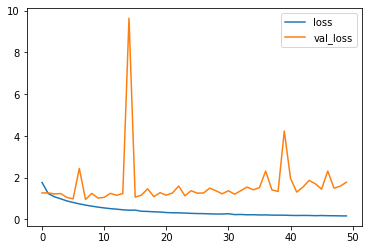

In [9]:
# Now look at the results

# Plot the loss
plt.plot(r_1.history['loss'], label = 'loss')
plt.plot(r_1.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

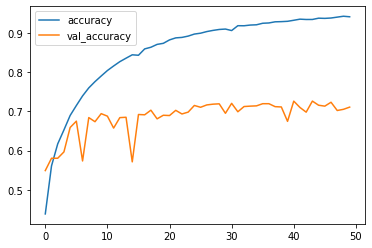

In [10]:
# Plot the accuracy
plt.plot(r_1.history['accuracy'], label = 'accuracy')
plt.plot(r_1.history['val_accuracy'], label = 'val_accuracy')
plt.legend()
plt.show()

In [11]:
# Apply the data augmentation to ALREADY trained model. So the model will continue training where it left off 
batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range = .1, height_shift_range = .1, horizontal_flip = True)
train_generator = data_generator.flow(x_train, y_train, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size
r_1_da = model_1.fit_generator(train_generator, validation_data = (x_test, y_test), steps_per_epoch = steps_per_epoch, epochs = 50)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 1562 steps, validate on 10000 samples
Epoch 1/50
1562/1562 [==============================] - 41s 26ms/step - loss: 1.1426 - accuracy: 0.6217 - val_loss: 0.8560 - val_accuracy: 0.7154
Epoch 2/50
1562/1562 [==============================] - 41s 26ms/step - loss: 0.9565 - accuracy: 0.6752 - val_loss: 0.8746 - val_accuracy: 0.7123
Epoch 3/50
1562/1562 [==============================] - 41s 26ms/step - loss: 0.9182 - accuracy: 0.6886 - val_loss: 0.8747 - val_accuracy: 0.7276
Epoch 4/50
1562/1562 [==============================] - 41s 27ms/step - loss: 0.8970 - accuracy: 0.6971 - val_loss: 1.1393 - val_accuracy: 0.7175
Epoch 5/50
1562/1562 [==============================] - 41s 27ms/step - loss: 0.8654 - accuracy: 0.7063 - val_loss: 0.8031 - val_accuracy: 0.7420
Epoch 6/50
1562/1562 [==============================] - 41s 27ms/step - loss: 0.8428 - accuracy: 0.7130 - val_loss: 0.810

In [12]:
# Only train with data augmentation
r_2_data_augmentation = model_2.fit(train_generator, validation_data = (x_test, y_test), steps_per_epoch = steps_per_epoch, epochs = 50)

  ...
    to  
  ['...']
Train for 1562 steps, validate on 10000 samples
Epoch 1/50
1562/1562 [==============================] - 42s 27ms/step - loss: 0.5611 - accuracy: 0.8110 - val_loss: 2.3058 - val_accuracy: 0.7427
Epoch 2/50
1562/1562 [==============================] - 42s 27ms/step - loss: 0.5702 - accuracy: 0.8094 - val_loss: 0.8007 - val_accuracy: 0.7826
Epoch 3/50
1562/1562 [==============================] - 42s 27ms/step - loss: 0.5529 - accuracy: 0.8139 - val_loss: 1.0012 - val_accuracy: 0.7760
Epoch 4/50
1562/1562 [==============================] - 43s 28ms/step - loss: 0.5458 - accuracy: 0.8150 - val_loss: 0.7131 - val_accuracy: 0.7993
Epoch 5/50
1562/1562 [==============================] - 43s 28ms/step - loss: 0.5410 - accuracy: 0.8167 - val_loss: 0.6951 - val_accuracy: 0.8083
Epoch 6/50
1562/1562 [==============================] - 43s 28ms/step - loss: 0.5411 - accuracy: 0.8170 - val_loss: 0.7410 - val_accuracy: 0.7885
Epoch 7/50
1562/1562 [=============================

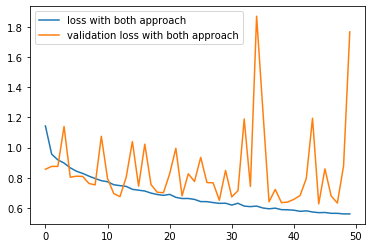

In [15]:
# Plot the both results

# Losses
plt.plot(r_1_da.history['loss'], label = 'loss with both approach')
plt.plot(r_1_da.history['val_loss'], label = 'validation loss with both approach')
plt.legend()
plt.show()

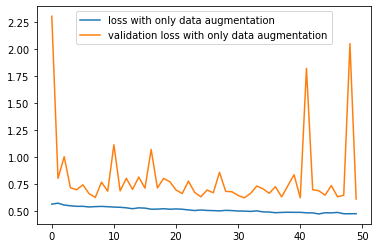

In [16]:
plt.plot(r_2_data_augmentation.history['loss'], label = 'loss with only data augmentation')
plt.plot(r_2_data_augmentation.history['val_loss'], label = 'validation loss with only data augmentation')
plt.legend()
plt.show()

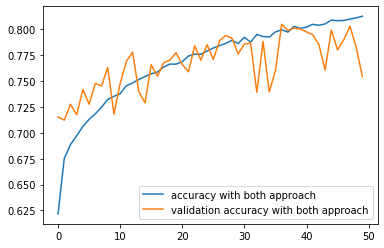

In [17]:
# Accuracies
plt.plot(r_1_da.history['accuracy'], label = 'accuracy with both approach')
plt.plot(r_1_da.history['val_accuracy'], label = 'validation accuracy with both approach')
plt.legend()
plt.show()

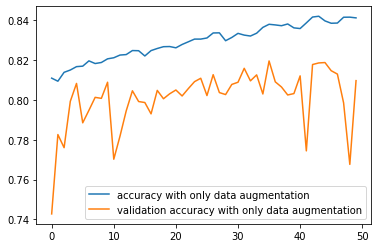

In [18]:
plt.plot(r_2_data_augmentation.history['accuracy'], label = 'accuracy with only data augmentation')
plt.plot(r_2_data_augmentation.history['val_accuracy'], label = 'validation accuracy with only data augmentation')
plt.legend()
plt.show()
# We can say that both models are pretty good. We can see the model that trained with both approach is better the model trained with only augmented data
# But training with only augmented data takes much less time than training with both approaches
# So that's a somewhat trade-off, In my opinion using the model that trained with both approaches is much more convenient than the using the other one

In [0]:
# Plot confusion matrix
# Code source: 
# https://colab.research.google.com/drive/11OHqNJQhT7rnNc2rmv7bs8uICkncgqWm

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'.
  """
  if normalize:
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix, without normalization')
  print(cm)

  plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment='center',
             color = 'white' if cm[i, j] > thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

p_test_1 = model_1.predict(x_test).argmax(axis = 1)
p_test_2 = model_2.predict(x_test).argmax(axis = 1)
cm1 = confusion_matrix(y_test, p_test_1)
cm2 = confusion_matrix(y_test, p_test_2)

Confusion matrix, without normalization
[[876  11  37  10  14   2   6   4  25  15]
 [  8 925   3   5   3   0   4   2  16  34]
 [ 54   2 721  55  44  29  66  15   8   6]
 [ 22   1  59 683  48  82  68  19   7  11]
 [  9   2  74  56 732  11  75  34   6   1]
 [ 13   1  36 184  42 660  31  25   5   3]
 [  7   4  22  31  17   4 911   2   2   0]
 [ 12   1  24  40  47  26   4 839   3   4]
 [ 62   9  11   6   6   2   3   0 884  17]
 [ 30  69   5  13   1   1   3   3   9 866]]


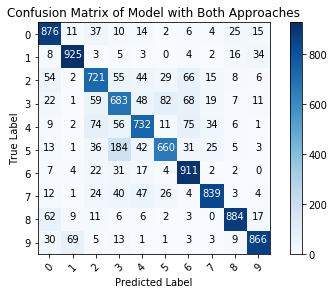

In [28]:
# plot the first confusion matrix
plot_confusion_matrix(cm1, list(range(10)), title = 'Confusion Matrix of Model with Both Approaches')

Confusion matrix, without normalization
[[876  11  37  10  14   2   6   4  25  15]
 [  8 925   3   5   3   0   4   2  16  34]
 [ 54   2 721  55  44  29  66  15   8   6]
 [ 22   1  59 683  48  82  68  19   7  11]
 [  9   2  74  56 732  11  75  34   6   1]
 [ 13   1  36 184  42 660  31  25   5   3]
 [  7   4  22  31  17   4 911   2   2   0]
 [ 12   1  24  40  47  26   4 839   3   4]
 [ 62   9  11   6   6   2   3   0 884  17]
 [ 30  69   5  13   1   1   3   3   9 866]]


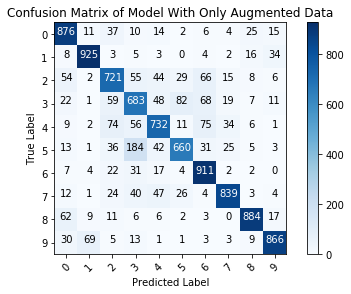

In [29]:
# plot the second one
plot_confusion_matrix(cm2, list(range(10)), title = 'Confusion Matrix of Model With Only Augmented Data')

Text(0.5, 1.0, 'Predicted: cat | True label: frog')

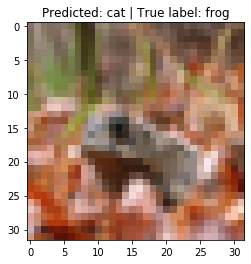

In [30]:
# show some of the misclassified examples
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
misclas_idx_1 = np.where(p_test_1 != y_test)[0]
misclas_idx_2 = np.where(p_test_2 != y_test)[0]
c1 = np.random.choice(misclas_idx_1)
c2 = np.random.choice(misclas_idx_2)
plt.imshow(x_test[c1])
plt.title('Predicted: {} | True label: {}'.format(labels[p_test_1[c1]], labels[y_test[c1]]))

Text(0.5, 1.0, 'Predicted: airplane | True label: automobile')

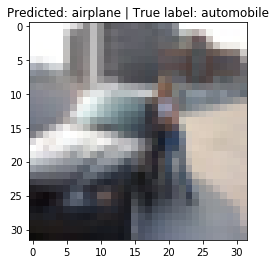

In [31]:
plt.imshow(x_test[c2])
plt.title('Predicted: {} | True label: {}'.format(labels[p_test_2[c2]], labels[y_test[c2]]))

In [25]:
# Now that the models are so large, it's useful to summarize it. But both model has the same architecture so their "summaries" are same.
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0     